#### Non-Alcoholic Fatty Liver Disease (NAFLD) Prediction using Machine Learning Algorithms

##### By: Mashhood Ahmad Khan (FA20-BSI-048) And Ali Hassan (FA20-BSI-006) Spring 2024


#### Step (1): Importing Libraries and Reading of Dataset

###### The first step in every Machine Learning project involves the importing of the desired Python libraries used in Data Analysis and Manipulation as well as for tasks involving Machine Learning. Here we have used the Pandas library to read the data from our dataset available in .csv file and dropped the unncessary columns to form a dataset containing relevant data

In [99]:
# Importing Required Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from joblib import dump
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Read the data from the datasets
nafld1 = pd.read_csv("C:\\Users\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\nafld1.csv")
nafld2 = pd.read_csv("C:\\Users\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\nafld2.csv")

# Merge the datasets on 'id'
merged_df = pd.merge(nafld2, nafld1, on='id', how='left')

# Sort the merged dataset by 'id' and 'days'
merged_df = merged_df.sort_values(by=['id', 'days']).reset_index(drop=True)
merged_data = merged_df.drop(['id', 'Unnamed: 0_x', 'Unnamed: 0_y', 'case.id', 'futime'], axis=1)

# Pivot the dynamic features
pivoted_df = merged_data.pivot_table(index=['age', 'male', 'weight', 'height', 'bmi', 'status'],
                                   columns='test', values='value', aggfunc='sum')

# Flatten the multi-level columns
pivoted_df.columns = ['_'.join(col).strip() for col in pivoted_df.columns.values]
pivoted_df = pivoted_df.reset_index()

merged_df_filepath = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\merged_dataset.csv"
pivoted_df.to_csv(merged_df_filepath, index=False)
alldata = pivoted_df.copy()

#### Step (2): Data Preprocessing and Feature Selection

###### The second step involves the removal of unnecessary columns and splitting the data into two sections for comparison. Here, we have split the data in two variables 'x' and 'y'. 'x' contains 'Features' such as Age, Weight, Height, BMI and different metabolic tests which is compared with the 'Target' which is the 'status' column in the 'y' variable. Then, we will preprocess the data by imputing the NULL/NaN values as well as scaling them appropriately. Finally, we shall split the data into 'Training' data and 'Testing' data

In [100]:
#Feature Selection and Data Preprocessing

# Separating features and target (feature selection)
x = alldata.drop('status', axis=1)
y = alldata['status']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)

# Scale features
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_imputed)

# Transforming scaled data back to DataFrame
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
x_scaled = x_scaled.drop(['f_i_b_4', 'h_d_l'], axis=1)

# Splitting data into 'training data' and 'testing data'
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.30, random_state=30)
x_train_filepath = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\x_train.csv"
x_train.to_csv(x_train_filepath, index=False)

# Apply BorderlineSMOTE to generate synthetic samples
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled, y_train_resampled = borderline_smote.fit_resample(x_train, y_train)

# Apply RandomUnderSampler to undersample the majority class
rus = RandomUnderSampler(random_state=42)
x_train_resampled_undersampled, y_train_resampled_undersampled = rus.fit_resample(x_train_resampled, y_train_resampled)

# Apply ADASYN to generate synthetic samples for minority class based on minority class density
ada = ADASYN(random_state=42)
x_train_preprocessed, y_train_preprocessed = ada.fit_resample(x_train_resampled_undersampled, y_train_resampled_undersampled)


test_file_path = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\processed_data.csv"
x_train_preprocessed.to_csv(test_file_path, index=False)

y_train_filepath = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\y_train_preprocessed.csv"
y_train.to_csv(y_train_filepath, index=False)


x_train_preprocessed.head()

,age,male,weight,height,bmi,c_h_o_l,d_b_p,s_b_p,s_m_o_k_e
0,0.1875,0.0,0.714093,0.583333,0.503702,0.063653,0.008990,0.008990,0.062500
1,0.5750,1.0,0.226568,0.535714,0.192515,0.273823,0.002332,0.002332,0.059562
2,0.4375,0.0,0.411328,0.357143,0.410447,0.110546,0.016968,0.016968,0.125000
3,0.2875,1.0,0.311531,0.785714,0.173793,0.022787,0.017955,0.017955,0.059562
4,0.3875,0.0,0.548213,0.523810,0.424696,0.088324,0.018962,0.018962,0.059562


##### Checking for any Class Imbalance in Pre-Processed Y_train

In [101]:
# Checking if pre-processed y_train is balanced

y_train_series = pd.Series(y_train_preprocessed)

# Calculating the counts for each class
class_counts = y_train_series.value_counts()
print(class_counts)

0    7886
1    7886
Name: status, dtype: int64


#### Step (3): Statistical Analysis of Data

###### Here, we will use the Matplotlib, Seaborn and Numpy libraries to perform statistical analysis of the data in order to find correlations and distributions within the data which could of interest before making and training a model

In [102]:
#Statistical Description of Scaled and Imputed Data

status_column = pd.DataFrame(y, columns=['status'])
combined_data = pd.concat([status_column, x_scaled], axis=1)
combined_data.head()


,status,age,male,weight,height,bmi,c_h_o_l,d_b_p,s_b_p,s_m_o_k_e
0,0,0.0,0.0,0.092380,0.428571,0.124369,0.108259,0.017955,0.017955,0.062500
1,0,0.0,0.0,0.237357,0.500000,0.212439,0.035970,0.012151,0.012151,0.125000
2,0,0.0,1.0,0.310182,0.690476,0.198816,0.108259,0.003007,0.003007,0.059562
3,0,0.0,1.0,0.328388,0.690476,0.211480,0.016761,0.017955,0.017955,0.059562
4,0,0.0,1.0,0.548213,0.761905,0.313967,0.036911,0.017955,0.017955,0.059562


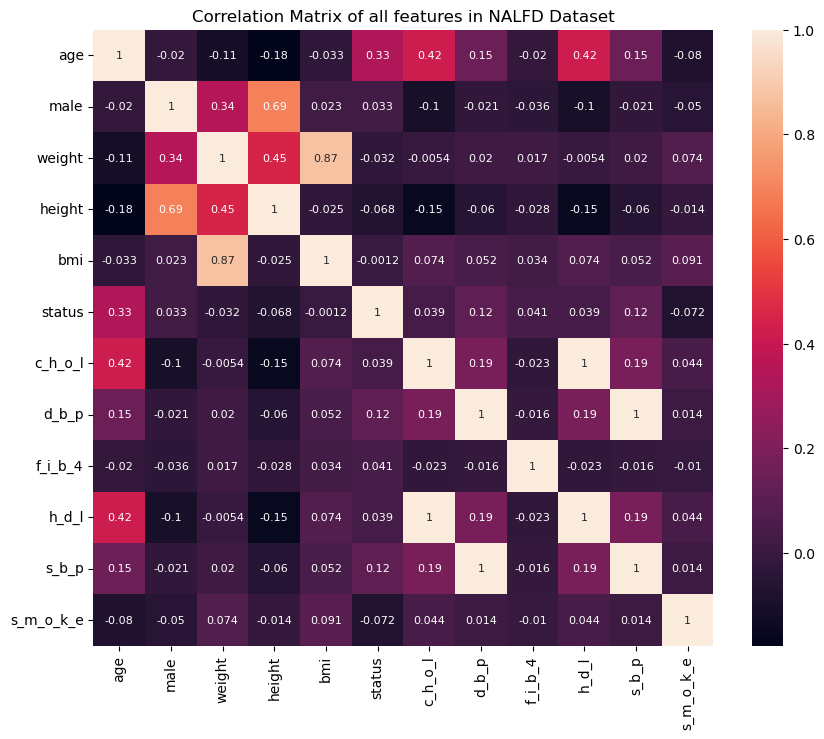

In [103]:
correlation_matrix = alldata.corr()
plt.figure(figsize=(10, 8))  #Adjusting heatmap size
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8})  #Adjusting annotation size
plt.title('Correlation Matrix of all features in NALFD Dataset')
plt.show()

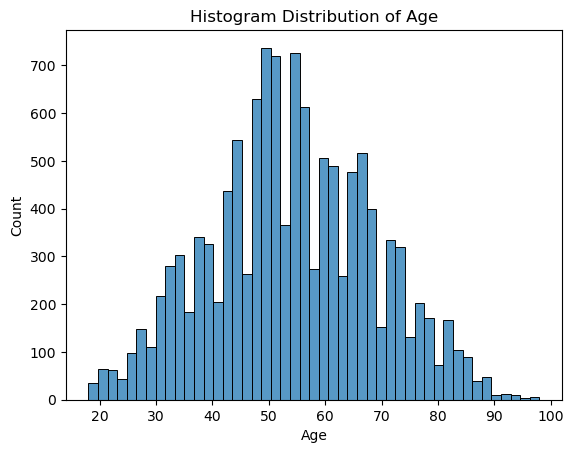

In [104]:
sns.histplot(alldata['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram Distribution of Age')
plt.show()

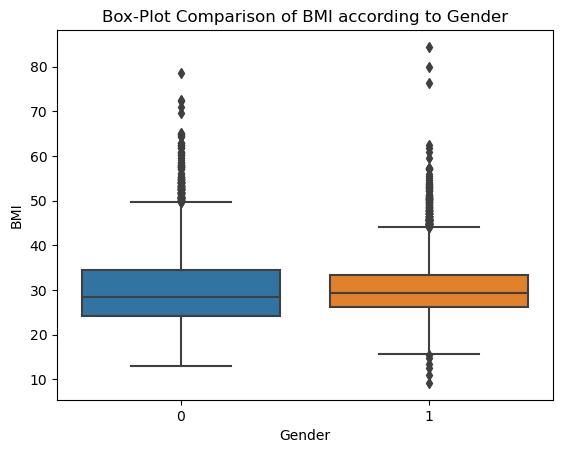

In [105]:
#Box-Plot Comparison of BMI in context with Gender

sns.boxplot(x='male', y='bmi', data=alldata)
plt.xlabel('Gender')
plt.ylabel('BMI')
plt.title('Box-Plot Comparison of BMI according to Gender')
plt.show()

#### Step (4.1): Training and Testing Model 1 (Random Forest Classifier)

###### Here, we will use the training and testing data and call the RandomForestClassifier() function to train the model using Random Forest Classifier Algorithm to learn random patterns in the data and test the accuracy and precision of the model

In [106]:
#Training and Testing Random Forest Classifier Model

# Instantiating the RandomForestClassifier with 250 trees
random_forest = RandomForestClassifier(n_estimators=250)

# Training the model
random_forest.fit(x_train_preprocessed, y_train_preprocessed)

# Predicting on the test set
predictions = random_forest.predict(x_test)

# Saving Random Forest Model
ranfor_model_path = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\models\\random_forest_model.joblib"
# Save Random Forest Classifier model
dump(random_forest, ranfor_model_path)

# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculating precision
precision = precision_score(y_test, predictions)

# Calculating recall
recall = recall_score(y_test, predictions)

# Calculating F1 score
f1 = f1_score(y_test, predictions)

print("Accuracy of Model (RFC): {:.2f}%".format(accuracy * 100))
print("Precision of Model (RFC): {:.2f}%".format(precision * 100))
print("Recall of Model (RFC): {:.2f}%".format(recall * 100))
print("F1 Score of Model (RFC): {:.2f}%".format(f1 * 100))

Accuracy of Model (RFC): 89.57%
Precision of Model (RFC): 42.09%
Recall of Model (RFC): 45.57%
F1 Score of Model (RFC): 43.76%


##### Confusion Matrix for Random Forest Classifier Model

###### This code computes the confusion matrix based on the predicted and actual values of a classification model. It then plots the confusion matrix as a heatmap using matplotlib.pyplot and seaborn. The matrix provides insights into the model's performance by showing the counts of true positives, true negatives, false positives, and false negatives. The color-coded heatmap highlights the distribution of predictions, with darker shades indicating higher values. The title, x-axis, and y-axis labels provide additional context for interpreting the confusion matrix.

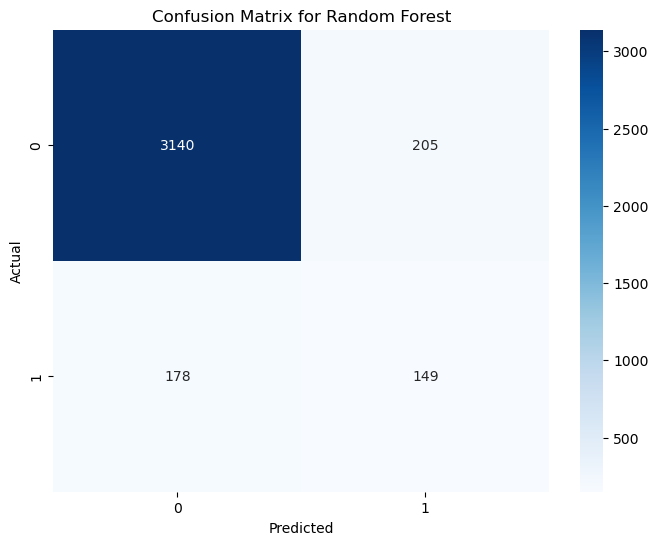

In [107]:
#Computing Confusion Matrix
conf_mat = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Step (4.2): Training and Testing Model 2 (Decision Tree Classifier)

###### Here, we will use the training and testing data and call the DecisionTreeClassifier() function to train the model using Decision Tree Classifier Algorithm to learn data patterns, split the data into nodes and test the accuracy and precision of the model. The Classification Report breaks down the accuracy, precision, recall and F1-scores for each individual class(0 and 1)

In [108]:
# Create and train the Decision Tree Classifier model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train_preprocessed, y_train_preprocessed)

# Predicting on the dataset
y_pred = decision_tree.predict(x_test)

# Saving Decision Tree Classifier Model
dectree_model_path = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\models\\decision_tree_model.joblib"
# Save Decision Tree Classifier model
dump(decision_tree, dectree_model_path)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculating precision
precision = precision_score(y_test, y_pred)

# Calculating recall
recall = recall_score(y_test, y_pred)

# Calculating F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy of Model (DTC): {:.2f}%".format(accuracy * 100))
print("Precision of Model (DTC): {:.2f}%".format(precision * 100))
print("Recall of Model (DTC): {:.2f}%".format(recall * 100))
print("F1 Score of Model (DTC): {:.2f}%\n".format(f1 * 100))

# Printing classification report
print(classification_report(y_test, y_pred))

Accuracy of Model (DTC): 85.38%
Precision of Model (DTC): 26.77%
Recall of Model (DTC): 37.00%
F1 Score of Model (DTC): 31.07%

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3345
           1       0.27      0.37      0.31       327

    accuracy                           0.85      3672
   macro avg       0.60      0.64      0.61      3672
weighted avg       0.88      0.85      0.86      3672



##### Confusion Matrix for Decision Tree Model

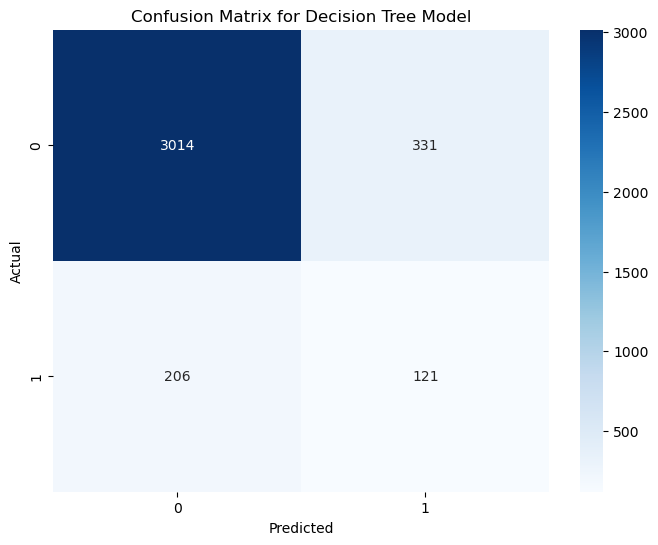

In [109]:
#Computing Confusion Matrix
conf_mat2 = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat2, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix for Decision Tree Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Step (4.3): Training and Testing Model 3 (Logistic Regression)

###### Here, we will use the training and testing data and call the LogisticRegression() function to train the model using Logistic Regression Algorithm

In [110]:
#Create and Train Logistic Regression Model
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train_preprocessed, y_train_preprocessed)

# Making predictions on dataset
lr_pred = logistic_regression.predict(x_test)

# Saving Logistic Regression Model
logreg_model_path = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\models\\logistic_regression_model.joblib"
# Save Logistic Regression model
dump(logistic_regression, logreg_model_path)

# Calculating accuracy
accuracy = accuracy_score(y_test, lr_pred)

# Calculating precision
precision = precision_score(y_test, lr_pred)

# Calculating recall
recall = recall_score(y_test, lr_pred)

# Calculating F1 score
f1 = f1_score(y_test, lr_pred)

print("Accuracy of Model (LogReg): {:.2f}%".format(accuracy * 100))
print("Precision of Model (LogReg): {:.2f}%".format(precision * 100))
print("Recall of Model (LogReg): {:.2f}%".format(recall * 100))
print("F1 Score of Model (LogReg): {:.2f}%\n".format(f1 * 100))

Accuracy of Model (LogReg): 78.27%
Precision of Model (LogReg): 25.08%
Recall of Model (LogReg): 72.48%
F1 Score of Model (LogReg): 37.26%



##### Confusion Matrix for Logistic Regression Model

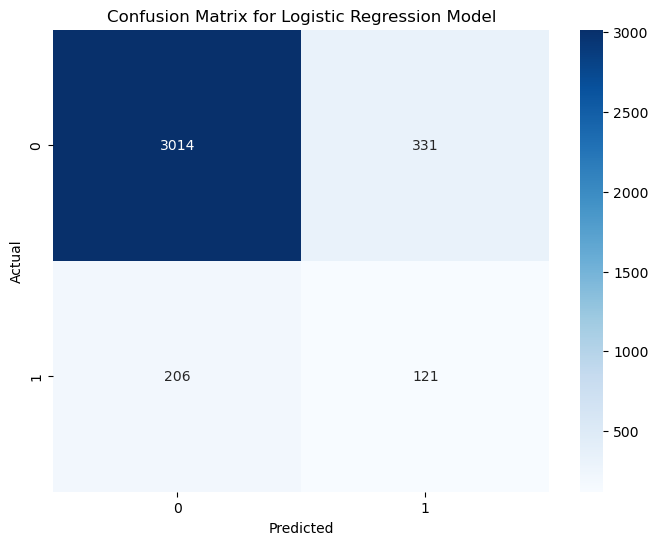

In [111]:
#Computing Confusion Matrix
conf_mat3 = confusion_matrix(y_test, lr_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat2, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Step (4.4): Training and Testing Model 4 (Gradient Boosting)

###### Here, we will use the training and testing data and call the GradientBoostingClassifier() function to train the model using Gradient Boosting Algorithm

In [114]:
# Create and Train Gradient Boosting CLassifier Model
gradient_boosting = GradientBoostingClassifier(random_state=42)
gradient_boosting.fit(x_train_preprocessed, y_train_preprocessed)

#Making predictions on the dataset
gdb_pred = gradient_boosting.predict(x_test)

# Saving Gradient Boosting Model
gradboost_model_path = "C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\models\\gradient_boosting_model.joblib"
# Save Gradient Boosting model
dump(gradient_boosting, gradboost_model_path)

# Calculating accuracy
accuracy = accuracy_score(y_test, gdb_pred)

# Calculating precision
precision = precision_score(y_test, gdb_pred)

# Calculating recall
recall = recall_score(y_test, gdb_pred)

# Calculating F1 score
f1 = f1_score(y_test, gdb_pred)

print("Accuracy of Model (GradBoost): {:.2f}%".format(accuracy * 100))
print("Precision of Model (GradBoost): {:.2f}%".format(precision * 100))
print("Recall of Model (GradBoost): {:.2f}%".format(recall * 100))
print("F1 Score of Model (GradBoost): {:.2f}%\n".format(f1 * 100))


Accuracy of Model (GradBoost): 85.92%
Precision of Model (GradBoost): 34.22%
Recall of Model (GradBoost): 63.00%
F1 Score of Model (GradBoost): 44.35%



##### Confusion Matrix for Gradient Boosting Model

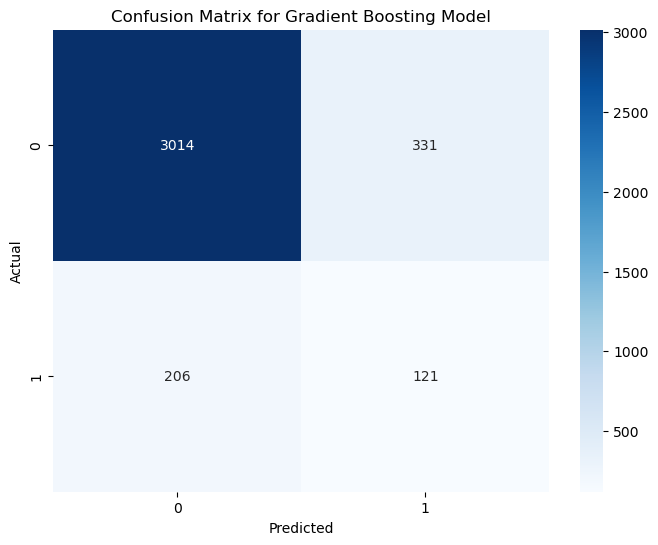

In [ ]:
#Computing Confusion Matrix
conf_mat4 = confusion_matrix(y_test, gdb_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat2, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix for Gradient Boosting Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Displaying performance results of the 4 ML Models (Random Forest, Decision Trees, Logistic Regression and Gradient Boosting)

###### Here we will form a disctionary called 'results' and will insert the different performance metrics (accuracy, precision, recall and F1-scores) for the 4 models in a Pandas dataframe and display the results in a tabulated format

In [ ]:
# Storing the results in a dictionary
results = {
    "Model": ["Random Forest Classifier", "Decision Tree Classifier", "Logistic Regression", "Gradient Boosting"],
    "Accuracy (%)": [],
    "Precision (%)": [],
    "Recall (%)": [],
    "F1 Score (%)": []
}

# Random Forest Classifier
accuracy_rf = round(accuracy_score(y_test, predictions) * 100, 2)
precision_rf = round(precision_score(y_test, predictions) * 100, 2)
recall_rf = round(recall_score(y_test, predictions) * 100, 2)
f1_rf = round(f1_score(y_test, predictions) * 100, 2)
results["Accuracy (%)"].append(accuracy_rf)
results["Precision (%)"].append(precision_rf)
results["Recall (%)"].append(recall_rf)
results["F1 Score (%)"].append(f1_rf)

# Decision Tree Classifier
accuracy_dt = round(accuracy_score(y_test, y_pred) * 100, 2)
precision_dt = round(precision_score(y_test, y_pred) * 100, 2)
recall_dt = round(recall_score(y_test, y_pred) * 100, 2)
f1_dt = round(f1_score(y_test, y_pred) * 100, 2)
results["Accuracy (%)"].append(accuracy_dt)
results["Precision (%)"].append(precision_dt)
results["Recall (%)"].append(recall_dt)
results["F1 Score (%)"].append(f1_dt)

# Logistic Regression
accuracy_lr = round(accuracy_score(y_test, lr_pred) * 100, 2)
precision_lr = round(precision_score(y_test, lr_pred) * 100, 2)
recall_lr = round(recall_score(y_test, lr_pred) * 100, 2)
f1_lr = round(f1_score(y_test, lr_pred) * 100, 2)
results["Accuracy (%)"].append(accuracy_lr)
results["Precision (%)"].append(precision_lr)
results["Recall (%)"].append(recall_lr)
results["F1 Score (%)"].append(f1_lr)

# Gradient Boosting
accuracy_gb = round(accuracy_score(y_test, gdb_pred) * 100, 2)
precision_gb = round(precision_score(y_test, gdb_pred) * 100, 2)
recall_gb = round(recall_score(y_test, gdb_pred) * 100, 2)
f1_gb = round(f1_score(y_test, gdb_pred) * 100, 2)
results["Accuracy (%)"].append(accuracy_gb)
results["Precision (%)"].append(precision_gb)
results["Recall (%)"].append(recall_gb)
results["F1 Score (%)"].append(f1_gb)


# Creating Pandas DataFrame
results_df = pd.DataFrame(results)

# Displaying the DataFrame
results_df


,Model,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
0,Random Forest Classifier,89.81,43.11,44.95,44.01
1,Decision Tree Classifier,85.38,26.77,37.00,31.07
2,Logistic Regression,78.27,25.08,72.48,37.26
3,Gradient Boosting,85.92,34.22,63.00,44.35


#### Heat Map of all features with the target variable

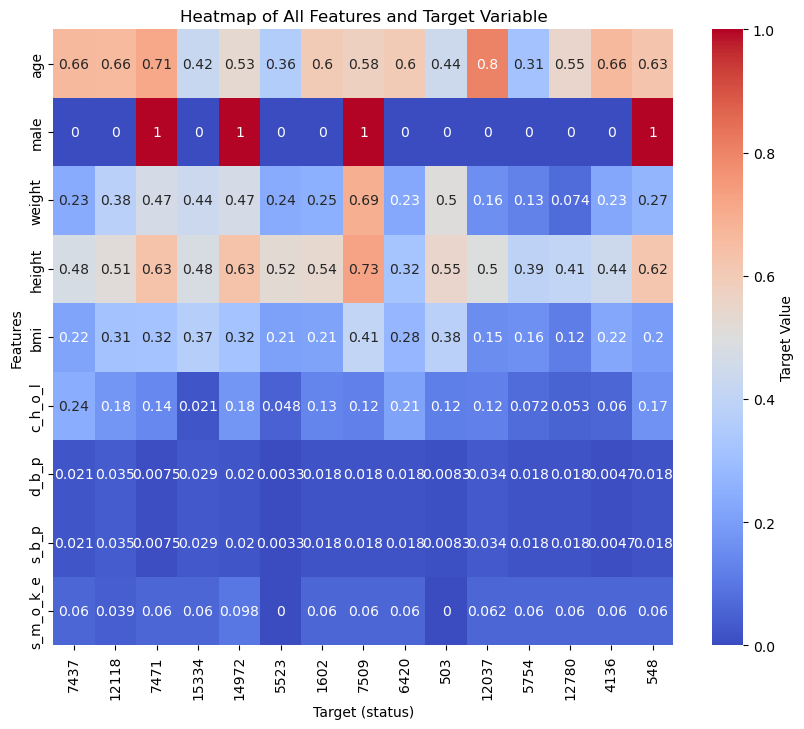

In [ ]:
# Selecting a random subset of 15 rows from x_train_resampled
subset = x_train_resampled.sample(15)

# Creating a heatmap for all features and the target variable
plt.figure(figsize=(10, 8))
sns.heatmap(subset.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]].T, annot=True, cmap='coolwarm', cbar_kws={'label': 'Target Value'})

plt.title("Heatmap of All Features and Target Variable")
plt.xlabel("Target (status)")
plt.ylabel("Features")
plt.show()

##### Testing Prediction Capability of the 4 ML Models by using a test data file and saving results as test_file_predictions.csv

In [ ]:
# Testing prediction capability of ML Models on a test data file

import pandas as pd
import joblib

# Load test data from CSV file
test_data = pd.read_csv('C:\\Users\\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\test_data.csv')

rf = joblib.load('./models/random_forest_model.joblib')
dt = joblib.load('./models/decision_tree_model.joblib')
lr = joblib.load('./models/logistic_regression_model.joblib')
gb = joblib.load('./models/gradient_boosting_model.joblib')


# Make predictions using your trained models (assuming you have them loaded)
predictions_rf = rf.predict(test_data)
predictions_dt = dt.predict(test_data)
predictions_lr = lr.predict(test_data)
predictions_gb = gb.predict(test_data)

# Create a new DataFrame to store predictions
predictions_df = pd.DataFrame({
    'RF_Prediction': predictions_rf,
    'DT_Prediction': predictions_dt,
    'LR_Prediction': predictions_lr,
    'GB_Prediction': predictions_gb
})

# Combine predictions with original test data
results_df = pd.concat([test_data, predictions_df], axis=1)

# Save results to a new CSV file
test_file_pred_filepath = "C:\\Users\Mashhood Ahmad Khan\\Desktop\\FYP Project By Mashhood and Ali Spring 2024\\data\\test_file_predictions.csv"
results_df.to_csv(test_file_pred_filepath, index=False)
